Monte Carlo Simulation
======================

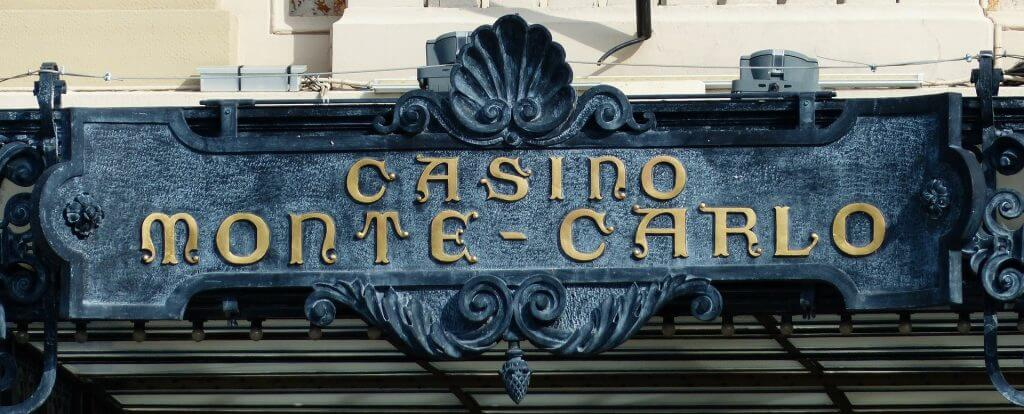

## Basics

Monte Carlo simulation is a general term for introducing the notion of uncertainty into statistical estimations.

The fundamentals were developed by nuclear researchers at Los Alamos National Laboratory to simulate the yield from nuclear weapons.

Michael McKay created a method called **Latin Hypercube Sampling** that allows for systematic sampling for the values of several variables, each from their own distributions, to characterize an uncertain input space.

For now, we'll do a simple model of uncertainty.

In [260]:
import numpy as np
import pandas as pd

## A Casino Application

Let's say we really want to visit a casino to have some fun gambling.   We want to figure out what game to play when we arrive and set out to analyze the chance of winning each.

We'll start with roulette.  After some research, we find that the casino's wheels have these characteristics.   We can use a random number between 1 and numbers_on the wheel to determine the outcome of any roll.  For example:

    numbers_on_wheel = 100
    losing_numbers = 2                                 # The '0' and '00' results
    red_numbers = 50                                   
    black_numbers = numbers_on_wheel - losing_numbers - red_numbers
    
We'll bet on red.    
    
In this example, 1 and 2 would lose.   A roll or 3-53 would be red (win).  54-100 would be black (lose).

For starters, let's say there are is no '0' or '00' on the wheel.   So we have:

In [261]:
numbers_on_wheel = 100
losing_numbers = 0                                 
red_numbers = 50                                    
black_numbers = numbers_on_wheel - losing_numbers - red_numbers

OK.  We've implemented the parameters of the game.  Now we need code to operationalize it.

Note that this function is very atomic.  

In [262]:
def roulette_roll(verbose=True):
    
    # Use the random() library to generate an outcome
    roll = np.random.randint(1, numbers_on_wheel)
    
    # Interpret the outcome per the rules for this casino's roulette wheel
    if roll > losing_numbers and roll < red_numbers + losing_numbers + 1:
        
        # The 'verbose' bit lets us silence the code when in production.
        if verbose:  
            print(f"The roll was {roll:>3}.  We Win!")
            
        # By default functions return None (which evaluates to False if asked)    
        return True
    
    else:
        if verbose:
            print(f"The roll was {roll:>3}.  We lose :-(" )
    

OK. We have our game set up so we can play.   

Let's try our luck:

In [263]:
for _ in range(5):
    roulette_roll()

The roll was  38.  We Win!
The roll was  13.  We Win!
The roll was  73.  We lose :-(
The roll was  10.  We Win!
The roll was  76.  We lose :-(


Let's now put the roulette wheel into the casino.   

The casino will have a dealer who spins the wheel and handles the bets.

Each turn, we'll make the same bet.   If we win, that amount gets added to our bank.  Otherwise our bank decreases by the amount bet.

In [264]:
# This is the first laywer of wrapping.  We have a named parameter for each element of the system we
#   may want to tweak - including the elements of the wrapped function (just 'verbose' here).

def gaming_session(bank=100, bet=1, games_per_session=3, verbose=False):
    games_so_far = 0
    wins = 0
    initial_bank = bank
    
    # Play a games and account for results
    while games_so_far < games_per_session:
        if roulette_roll(verbose): 
            bank += bet
            wins += 1
        else:
            bank -= bet
        if verbose:
            print(f"Bank: {bank}")
            
        games_so_far += 1
    
    if verbose:
        print(f"We played {games_per_session} won {wins} ({wins/games_per_session*100:.2f}%)  ") 
    
    # Return average win (or loss)
    return (initial_bank - bank ) / games_per_session
            

In [265]:
gaming_session(100, 1, 3)

0.3333333333333333

Now we can wrap an individual gaming session for one player into a casino full of players.

In [266]:
# This is the second layer of wrapping.   Note how this sets verbose for gaming_session(), 
#    which passes it through to roulette_roll().

verbose = False

def multi_player(players=10, bank=100, bet=1, games_per_session=3, verbose=verbose):
    " Simulates the play of a bunch of gamblers on the same game."
    players_so_far = 0
    results = []
    while players_so_far < players:
        results.append(gaming_session(bank, bet, games_per_session, verbose=verbose))
        players_so_far += 1
        
    return results

Finally, we'll set up some code to call the multi_player() routine and capture the results.

In [267]:
#  This is the outer layer of wrapping.   We set the parameters that will feed into multi_player() ..
#     .. which sends to gaming_session() .. which sends them to roulette_roll().

# Parameters for this run
players = 200
bank = 100
games_per_session = 30
bet = 1
verbose = False

# Capture the aggregated results
results = multi_player(players=players, bank=bank, bet=bet,
                       games_per_session=games_per_session, verbose=verbose)

if verbose:
    print(f"Winning percent for each player:\n\n{results}")

Let's have a look at the results.

This shows the average winnings.  For a $1 bet, this is also the 'percent profit' for each player.


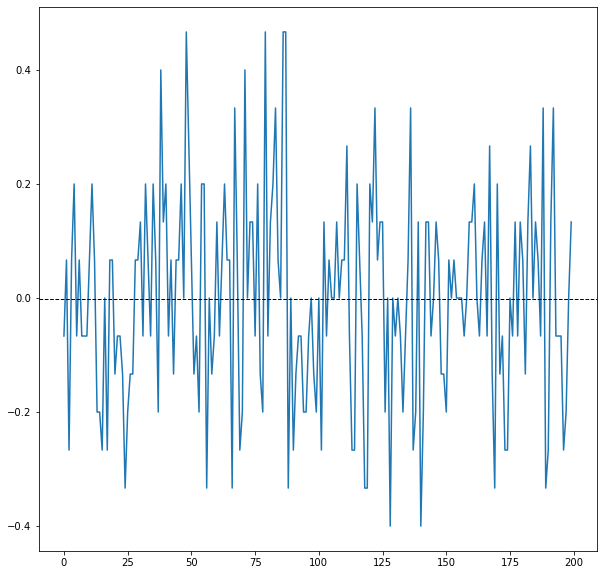

In [268]:
import matplotlib.pyplot as plt
 
avg_list = np.array(results)
plt.figure(figsize=(10,10))
plt.plot(avg_list)
plt.axhline(np.array(avg_list).mean(), color='k', linestyle='dashed', linewidth=1)


## Sampling an Unknown Distribution

Another way we can use Monte Carlo simulation is to learn about an unknown distribution.  

This is an important topic when we try to find a Maximum Likelihood Estimation (MLE) solution.   That's when we think we know the general distribution for a data set (normal, maybe) and we try to find the best values of the mean and standard deviation.   

"Best" means that we minimize the errors between the distribution implied by our estimated values and the actual, observed distribution.

If our distributions are parametric (that means they can be described by an equation), the process is pretty straightforward - we can do things like find minimum and maximum values by setting the first derivative to zero then solving for the parameters.  Or we can solve for the value at any point under the distribution.

If our distributions are nonparametric, or if we have a high-dimension data space, the analytical solutions may be intractable or too expensive.  In these cases, we need to sample the space to discover its characteristics.

In this example we will:

    Generate a funky, but parametric distribution...

    ... but pretend we don't know what it looks like.

    Use sampling to discover its characteristics.

    Check how well the sampling did (we're cheating, after all)!

## Generate a Distribution

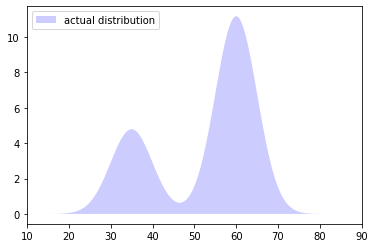

In [269]:
# Import matplotlib's plotting tool, the Gaussian (normal) distribution from scipy,
#   and scipy's stats package.

import matplotlib.pyplot as plt
from scipy.stats import norm, stats


#  Use np.linspace to create even increments  np.linspace(<high>, <low>, <intervals>)
#     np.newaxis is an alias for None.  This creates a 2d array with shape (1000, 1).
X_plot = np.linspace(10, 100, 1000)[:, np.newaxis]

# Create our funky distribution.   This is really two normal distributions, scaled and
#    smooshed together.
true_dens = (0.3 * norm(35, 5).pdf(X_plot[:, 0])  + \
             0.7 * norm(60, 5).pdf(X_plot[:, 0])) * \
            200

#  Let's have a look ..
fig, ax = plt.subplots()

# This is what we'll plot  ax_fill(<x-values>, <y-values>, <some aesthetics>)
ax.fill(X_plot[:, 0], true_dens, fc='blue', alpha=0.2,label='actual distribution')

# Add a couple more aesthetics.
ax.legend(loc='upper left')
ax.set_xlim(10, 90)

# Show the plot, then reset it for the next use.
plt.show()
plt.close()

OK.   This is our "unknown" distribution.   This may be the response surface of a high-dimension parameter space we're trying to resolve to generate a prior for a Bayesian simulation.  It doesn't really matter, but we can't solve it with numerical methods.

## Making Observations

But we can observe it.   This function essentially replicates the equation(s) that generated our solution space.  This will be the "world" that we'll explore.

If we pass it x it will return some f(x):

In [270]:
def generate_obs(x):
    "Return a single point from the distributino"
    return (0.3 * norm(35, 5).pdf(x)  + \
            0.7 * norm(60, 5).pdf(x)) * \
                200

We can test it out with a few numbers to make sure it's reasonable:

In [271]:
# This should be about the peak.
generate_obs(60)

11.170401691874291

In [272]:
# This should be a low value.
generate_obs(50.12)


1.6350973427331514

Let's have a look at some summary data for our distribution.    If our sampling is any good, we should be able reproduce these stats (more or less) from our observations.

In [273]:
original_stats = stats.describe(true_dens)
original_stats

DescribeResult(nobs=1000, minmax=(1.4146359033903299e-13, 11.170401691874291), mean=2.219999817876447, variance=9.630551838150744, skewness=1.5346304017651526, kurtosis=1.3675053628668294)

## Explore the Dataspace

Create a routine that wraps up our generate_obs() function.  It randomly creates some x-values and sorts them (that way our plot will be interpertable).

In [274]:
random.seed(1)

In [275]:
import random
def query_data(lower=20, upper=80, n_obs=100, verbose=False, seed=1):
    " Generate a list of results of the generate_obs() function from random inputs"
    
    random.seed(1)
    
    # Use random.uniform() to create random values and create a list
    observations = []
    x = [random.uniform(lower, upper) for _ in range(n_obs)]
    
    # Sort the list.  That will make our plot actually readable.
    #   NB:  x.sort() returns None so we can't add sort() to our definition of x
    x.sort()
    
    # Runs through our random inputs and remenbers the results
    for xval in x:                
        obs = generate_obs(xval)
        observations.append(obs) 
        if verbose:  
            print(f"f({xval:2.3f}) = {obs:2.3f}")
            
    return x, observations      

We'll sample the data using the query_data() routine here, then plot it in the next cell.

In [276]:
# Query the distribution.  You probably want to leave the bounds close to 20 and 80, but play with the n_obs.
n_obs = 100    
lower = 20
upper = 75

x, obs = query_data (lower=lower, upper=upper, n_obs=n_obs, verbose=False)   

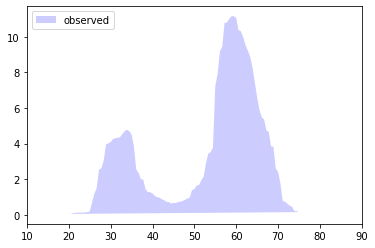

In [277]:
obs_array = np.array(obs)

# Create instances of matplotlib.plt objects
fig, ax = plt.subplots()

# Create the x-values and y-values to plot.  The y-values will be a Numpy array.
X_plot = np.linspace(lower, upper, n_obs)[:, np.newaxis]
y_plot = np.array(obs)

# Specify the plot object.
ax.fill(X_plot[:, 0], y_plot, fc='blue', alpha=0.2, label='observed')
ax.legend(loc='upper left')
ax.set_xlim(10, 90)

# Et, voila!
plt.show()


Depending on your n_obs, you'll see the original distribution (more or less).  The lower the N, the more jagged it'll look.   It passes the "eyeball test".   

What about the stats?

In [278]:
estimated_stats = stats.describe(obs) 
estimated_stats

DescribeResult(nobs=100, minmax=(0.05699450221314087, 11.148220700551677), mean=3.4505622762450874, variance=11.296172934949421, skewness=1.0352910281606234, kurtosis=-0.1270675199605238)

In [279]:
# A tuple of tuples that we can unpack.  This format is pretty easy to read/maintain IMHO.

comps = ( ('mean',  original_stats.mean, estimated_stats.mean), 
          ('var ',  original_stats.variance, estimated_stats.variance),
          ('max ',  original_stats.minmax[1], estimated_stats.minmax[1]),       
        )

print("Results:\n")
for stat, orig, est in comps:
    print(f"stat: {stat} orig: {orig:2.3f}  est: {est:2.3f}, delta: {orig-est:2.3f}")

Results:

stat: mean orig: 2.220  est: 3.451, delta: -1.231
stat: var  orig: 9.631  est: 11.296, delta: -1.666
stat: max  orig: 11.170  est: 11.148, delta: 0.022


## Refining the Exploration

Our estimates seem a bit off, don't they?   The reason has a lot to do with our sampling design.   We may be sampling with too wide a range of x-values, essentially querying for "empty" parts of the range of y-values.  It could be many things, but that's OK.  The mean isn't the best test for a distribution without a centeral tendancy.

Besides, we're seldom interested in the whole distribution.  In a complex data space, it would take a really long time to sample everything, anyway.   Usually sampling is 'adaptive'.  That means that the next sample depends on what we have learned about past samples.   We're typically interested in finding 'gradients'.  You can think of these as slopes.  If we're looking for a local maximum, we can do a 'hill climbing' exercise to take the steepest path to the top.

Here's how we might do it:

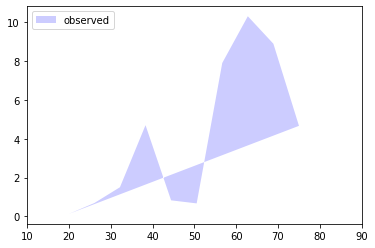

In [280]:
n_obs = 10    
lower = 20
upper = 75

# Query the data
x, obs = query_data (lower=lower, upper=upper, n_obs=n_obs, verbose=False) 
obs_array = np.array(obs)

# Create instances of matplotlib.plt objects
fig, ax = plt.subplots()

# Create the x-values and y-values to plot.  The y-values will be a Numpy array.
#  The " [:.newaxis]" bit is an ideom that 
X_plot = np.linspace(lower, upper, n_obs)[:, np.newaxis]
y_plot = np.array(obs)

# Specify the plot object.
ax.fill(X_plot[:, 0], y_plot, fc='blue', alpha=0.2, label='observed')
ax.legend(loc='upper left')
ax.set_xlim(10, 90)

# Et, voila!
plt.show()

It's easy to 'eyeball' the result.  The max value will be somewhere between x = 55 and x = 70.

Let's print the actual values.   First we'll combine x and f(x) into a single array:

In [281]:
# Create an ndarray with columns (x, f(x)).  This simply combines the columns.
#   Note: there's also a method np.hstack() that combines rows.

xy = np.stack((np.array(x), obs_array), axis=1)

xy

array([[21.55911121,  0.12909823],
       [25.16227727,  0.69097775],
       [27.39003343,  1.50341065],
       [34.02879642,  4.6978581 ],
       [44.72200856,  0.82784055],
       [47.24892979,  0.67051878],
       [55.8376135 ,  7.89997283],
       [62.00760404, 10.30528336],
       [63.37978431,  8.88893452],
       [66.60885553,  4.66331491]])

We can scan these values to figure out the row we need.  

For simplicity we'll define a function to simply return the values.

In [282]:
def get_max_xy(xy_arr):
    " Input is two-col ndarray.  Cols: [x, f(x)].  Returns x and f(x) at max f(x) value."
    
    max_row = xy_arr[np.where(xy[:,1] == np.max(xy_arr[:,1]))][0]
    x_max, y_max = max_row[0], max_row[1]

    return x_max, y_max

In [283]:
print(get_max_xy(xy))

(62.00760404371377, 10.30528336267572)


Yes, that's a horrible equation!   Numpy can be that way.  Pandas is a bit more kind.

But, let's break it down, anyway, so you'll get a sense of how all this gobbledy-gook works.

In [284]:
# Isolate the f(x) column with a slice
f_x_col = xy[:,1]

print(f"First few rows of f(x) column:\n {x_col[:3]}\n" )

# Find the max value of f(x)
max_f_x = np.max(f_x_col)

print(f"The max value is {max_f_x}\n")

# Figure out what row the max value occurs in
max_row_num  = np.where(f_x_col == max_f_x)

print(f"... which is in row {max_row_num[0]}\n")

# Grab the row that contains the maximum f(x) value (strip the first element with '[0][0]' bit)
max_row = xy[max_row_num, :][0][0]

print(f"The row with the x, f(x) values where f(x) is maxed out:\n{max_row}\n")

# Capture the x and y values
x_max, y_max = max_row[0], max_row[1]

print(f"x: {x_max}   y: {y_max}")


First few rows of f(x) column:
 [0.1471886  1.73928458 1.96178627]

The max value is 10.30528336267572

... which is in row [7]

The row with the x, f(x) values where f(x) is maxed out:
[62.00760404 10.30528336]

x: 62.00760404371377   y: 10.30528336267572


## Recap

We have created a bunch of stuff so far:

    A parametrically-created bimodal distribution (which we'll pretend is not).

    A means of sampling the distribution

    A means of analyzing the sample results

Next, we'll implement a crude gradient search and see if we can't find the maximum value.

## Gradient Search

A gradient search will explore the data space based on the slope.  The 'slope' can be high-dimension and a bit hard to see or understand.   For now, accept that the concept that we can work with in 2-D space is completely extensible.

We'll build a very simple gradient search tool to demonstrate how and where Monte Carlo techniques play.

We'll begin with a reasonable guess based on our first sample:

In [285]:
guess0 = x_max
result0 = y_max


Now, we'll try values of x on either side of the current guess.  The idea is to find the direction of the most improvement.   If we're in a 'saddle', both directions might be higher.   

How far do we move x?  In practice, that might be variable.   Big steps can cover a lot of ground quickly, but likely will not find the true maximum.   Small steps can take forever and the analysis may get tricked into thinking a local maximum is the global one.  We'll just go ahead and pick an arbitrary one.

    step = 1

Another factor is how far in the distance to look in either direction.  Some sort of averaging likely makes sense because the 'molehill' right next door is probably not representative.  We might create a 'frame of reference' to define how many values either way we'll sample.  We'll pick another arbitrary value:

    frame = 3

In [286]:
step = 1
frame = 3
guess = x_max

Let's build a couple of tools to handle these

In [287]:
from statistics import mean

def next_x_vals(guess, frame=3, step=1, direction='up'):
    """Create and return a vector such that each element is 'step' different
         from the last, starting at guess +/- step, depending on the 
         'direction'.  The length of the vector is 'frame'.  """
    
    return_list = []
    for ix in range(frame ):
        if direction == 'up':
            return_list.append(guess + ix * step)
        else:
            return_list.append(guess - ix * step)
            
    return return_list
            
    
def next_y_vals(next_x_vals, func):
    """ Given a vector of next_x_vals and a function, create and return a vector of f(x)."""
    
    return_vector = []
    
    for x in next_x_vals:
        return_vector.append(func(x))        
    return return_vector


def gradient_search_max(guess, func, lower_bound, upper_bound, step, frame, direction=None):
    """Conduct a gradient search to find max value of a solution space."""  
    
    DEBUG = False
    
    # Remember the oringinal guess
    original_guess = guess
    original_result = func(original_guess)
    if DEBUG: print(f"current: x {original_guess:.2f}   y {original_result:.2f}")
    
    # Find x values for a few steps higher and lower than current guess.
    x_going_up = next_x_vals(guess, frame, step, 'up')
    x_going_down = next_x_vals(guess, frame, step, 'down')
    if DEBUG: print(x_going_up, x_going_down)
    
    
    # Find corresponding mean y values
    y_going_up = mean(next_y_vals(x_going_up, func))
    y_going_down = mean(next_y_vals(x_going_down, func))
    if DEBUG: print(f"y_going_down: {y_going_down:.2f}  y_going_up: {y_going_up:.2f} ")
    
    
    # Figure out if we're going up or down
    if direction is None:
        if y_going_up >= original_result and y_going_up >= y_going_down:
            direction = 'up'
        if y_going_down > original_result and y_going_up < y_going_down:
            direction = 'down' 
        print(f"We're searching {direction}.")
    
    # Adjust the guess as needed
    if direction == 'up' and y_going_up >= original_result:
        guess = original_guess + step
    elif direction == 'down'  and y_going_down >= original_result:
        guess = original_guess - step
            
    # We'll keep going if the guess changed and it's within bounds. Otherwise we're done.
    if guess != original_guess and guess >= lower_bound and guess <= upper_bound:
        print(f"Current answer:  x: {guess:.2f}  y: {func(guess):.2f}")
        gradient_search_max(guess, func, lower_bound, upper_bound, step, frame, direction=direction)
        
    else:
        print(f"Final answer:  x: {guess:.2f}  y: {func(guess):.2f}")
        return guess

    
func = generate_obs
lower_bound_gradient = 0
upper_bound_gradient = 100
step = .1
frame = 3

gradient_search_max(guess, func, lower_bound_gradient, upper_bound_gradient, step, frame)
    


We're searching down.
Current answer:  x: 61.91  y: 10.39
Current answer:  x: 61.81  y: 10.46
Current answer:  x: 61.71  y: 10.54
Current answer:  x: 61.61  y: 10.61
Current answer:  x: 61.51  y: 10.67
Current answer:  x: 61.41  y: 10.74
Current answer:  x: 61.31  y: 10.79
Current answer:  x: 61.21  y: 10.85
Current answer:  x: 61.11  y: 10.90
Current answer:  x: 61.01  y: 10.95
Current answer:  x: 60.91  y: 10.99
Current answer:  x: 60.81  y: 11.03
Current answer:  x: 60.71  y: 11.06
Current answer:  x: 60.61  y: 11.09
Current answer:  x: 60.51  y: 11.11
Current answer:  x: 60.41  y: 11.13
Current answer:  x: 60.31  y: 11.15
Current answer:  x: 60.21  y: 11.16
Current answer:  x: 60.11  y: 11.17
Current answer:  x: 60.01  y: 11.17
Final answer:  x: 60.01  y: 11.17


In [288]:
print(f"original max value: {stats.describe(true_dens).minmax[1]:.2f}")

original max value: 11.17


## Exercise:

In this solution, we used a 'step' to sample the region of the distribution around our current guess.  So if our guess is 100, our frame is 3, and our step is 1 we would sample at [100, 101, 102] if we were going up.   We would sample at [100, 99, 98] if we were going down.

Using Monte Carlo we would randomize that sample within the region between 100 and 102 going up; and between 100 and 98 going down.  Can you write an alternative to next_x_vals() that would use random sampling instead of a fixed step size to accomplish the same goal?

